In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [7]:
# Function to load images and masks for training data
def load_data(path, img_size=(128, 128)):
    images = []
    masks = []
    
    for folder in os.listdir(path):
        img_folder = os.path.join(path, folder, "images")
        mask_folder = os.path.join(path, folder, "masks")
        
        # Load the image
        img_path = glob(os.path.join(img_folder, "*"))[0]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        images.append(img)
        
        # Initialize an empty mask
        combined_mask = np.zeros((img_size[0], img_size[1], 1), dtype=np.float32)
        
        # Load and combine all masks
        for mask_file in glob(os.path.join(mask_folder, "*")):
            m = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            m = cv2.resize(m, img_size)
            combined_mask = np.maximum(combined_mask, np.expand_dims(m, axis=-1))
        
        masks.append(combined_mask)
    
    return np.array(images) / 255.0, np.array(masks) / 255.0

# Load training data
train_images, train_masks = load_data('./data-science-bowl-2018/stage1_train')

In [8]:
# Function to load images for test data (no masks available)
def load_test_data(path, img_size=(128, 128)):
    images = []
    
    for folder in os.listdir(path):
        img_folder = os.path.join(path, folder, "images")
        
        # Load the image
        img_path = glob(os.path.join(img_folder, "*"))[0]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        images.append(img)
    
    return np.array(images) / 255.0

# Load test data
test_images = load_test_data('./data-science-bowl-2018/stage1_test')

In [9]:
# U-Net model definition
def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Expansive path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate and compile U-Net model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(train_images, train_masks, validation_split=0.2, batch_size=16, epochs=20)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.7598 - loss: 0.7346 - val_accuracy: 0.8515 - val_loss: 0.3853
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - accuracy: 0.8478 - loss: 0.3292 - val_accuracy: 0.8863 - val_loss: 0.2063
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.8661 - loss: 0.2891 - val_accuracy: 0.9116 - val_loss: 0.1811
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 217s 6s/step - accuracy: 0.9135 - loss: 0.1820 - val_accuracy: 0.9321 - val_loss: 0.1393
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 233s 7s/step - accuracy: 0.9306 - loss: 0.1434 - val_accuracy: 0.9438 - val_loss: 0.1056
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 216s 6s/step - accuracy: 0.9454 - loss: 0.1052 - val_accuracy: 0.9494 - val_loss: 0.0934
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.9469 - loss: 0.0987 - val_accuracy: 0.9528 - val_loss: 0.0831
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step - accuracy: 0.9467 - loss: 0.0965 - val_accuracy: 0.9539 - v

In [14]:
# Predict masks for test images
predicted_masks = model.predict(test_images)

# Convert predicted masks to binary (thresholding)
predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [15]:
# Save the predicted masks to a folder
output_folder = 'predicted_masks'
os.makedirs(output_folder, exist_ok=True)

for i, mask in enumerate(predicted_masks_binary):
    mask_image = (mask.squeeze() * 255).astype(np.uint8)  # Convert to 8-bit grayscale
    cv2.imwrite(os.path.join(output_folder, f"mask_{i}.png"), mask_image)

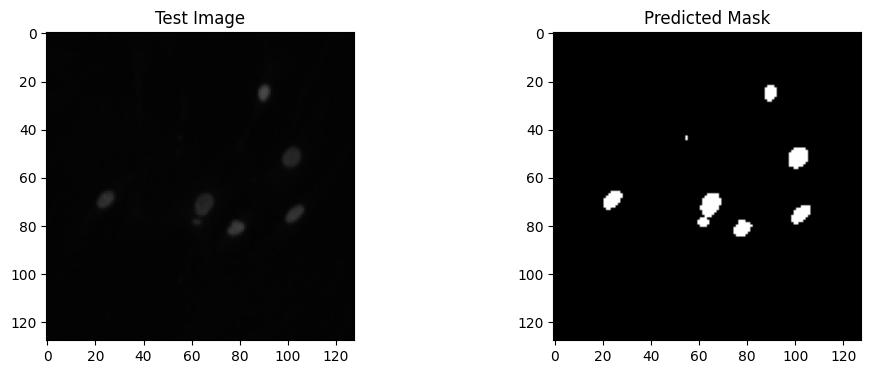

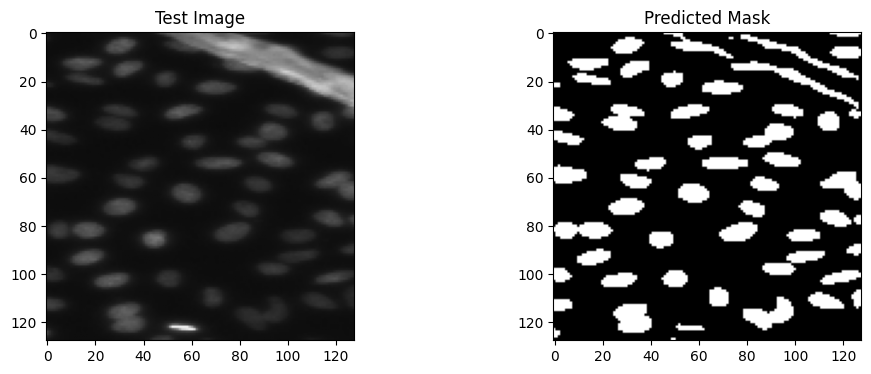

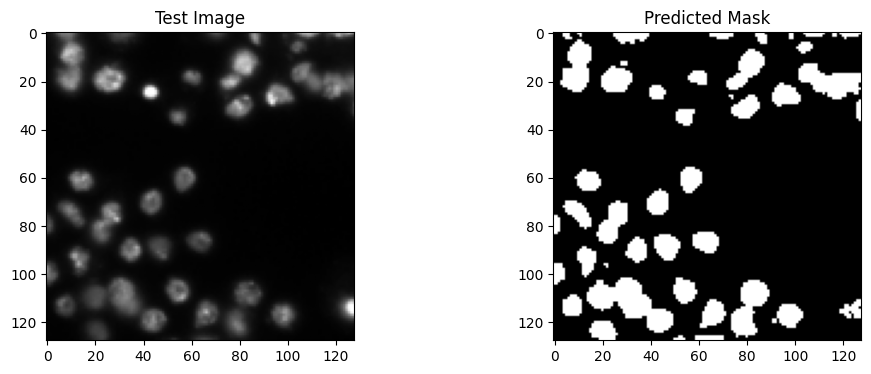

In [21]:
# Visualize test images and predicted masks
for i in range(3):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title('Test Image')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks_binary[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Binarize the true masks to make them comparable with binary predictions
train_masks_binary = (train_masks > 0.5).astype(np.uint8)

# Predict on training data
train_predictions = model.predict(train_images)

# Convert continuous predictions to binary using a threshold
train_predictions_binary = (train_predictions > 0.5).astype(np.uint8)

# Flatten the masks and predictions for metric calculation
flattened_true = train_masks_binary.flatten()  # Binarized true masks
flattened_pred = train_predictions_binary.flatten()  # Binary predictions

21/21 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step


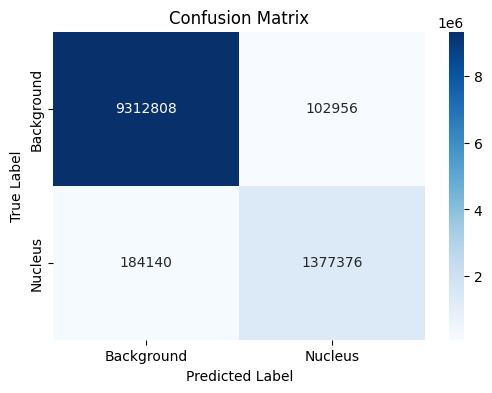

In [25]:
# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Nucleus"], yticklabels=["Background", "Nucleus"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

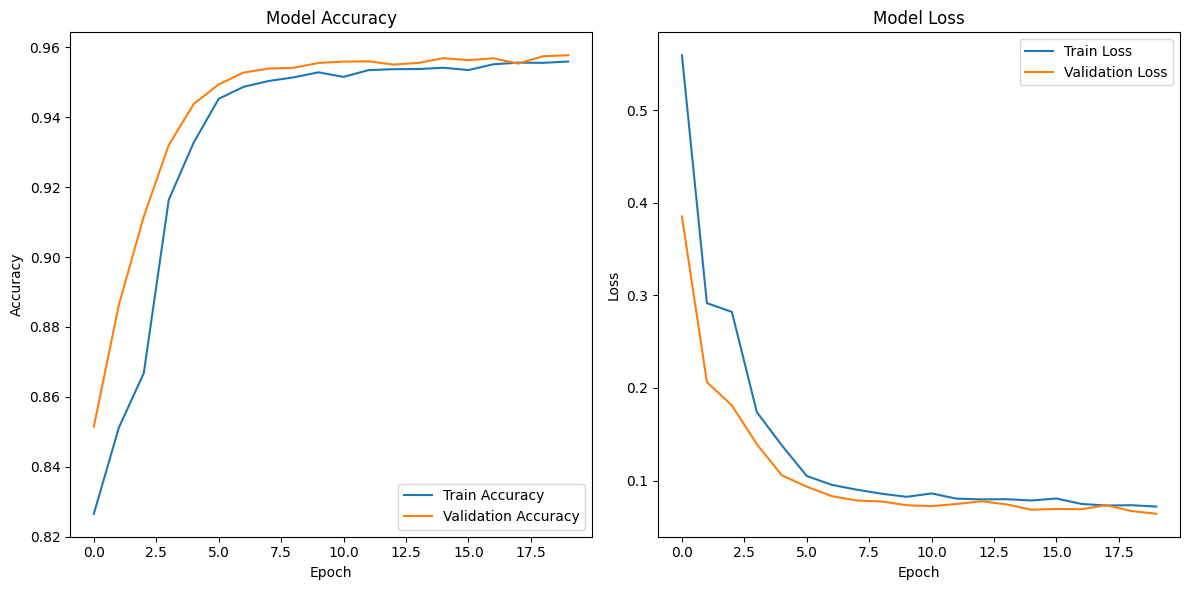

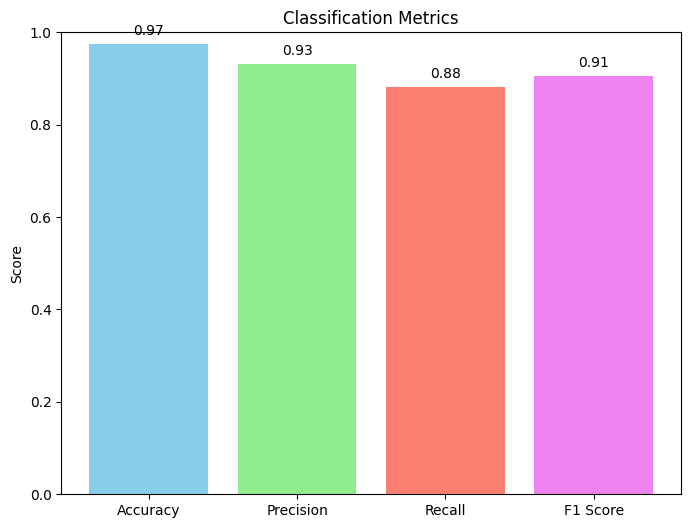

In [28]:
# Function to plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Function to plot accuracy, precision, recall, and F1 score
def plot_classification_metrics(accuracy, precision, recall, f1):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'violet'])
    plt.ylim(0, 1)  # Limit y-axis from 0 to 1
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

    plt.show()

# Example of calling the functions after training and evaluation
plot_training_history(history)  # history is from model.fit()
plot_classification_metrics(accuracy, precision, recall, f1)  # Metrics computed after evaluation

In [29]:
# Binarize the true masks to make them comparable with binary predictions
train_masks_binary = (train_masks > 0.5).astype(np.uint8)

# Predict on training data
train_predictions = model.predict(train_images)

# Convert continuous predictions to binary using a threshold
train_predictions_binary = (train_predictions > 0.5).astype(np.uint8)

# Flatten the masks and predictions for metric calculation
flattened_true = train_masks_binary.flatten()
flattened_pred = train_predictions_binary.flatten()

# Calculate classification metrics
accuracy = accuracy_score(flattened_true, flattened_pred)
precision = precision_score(flattened_true, flattened_pred)
recall = recall_score(flattened_true, flattened_pred)
f1 = f1_score(flattened_true, flattened_pred)

# Calculate IoU
def iou_score(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    return intersection / union if union != 0 else 1.0

iou = iou_score(flattened_true, flattened_pred)

# Calculate Dice Coefficient
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

dice = dice_coefficient(flattened_true, flattened_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU Score: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

# Compute and print the confusion matrix
cm = confusion_matrix(flattened_true, flattened_pred)
print("Confusion Matrix:")
print(cm)

21/21 ━━━━━━━━━━━━━━━━━━━━ 149s 7s/step
Accuracy: 0.9738
Precision: 0.9305
Recall: 0.8821
F1 Score: 0.9056
IoU Score: 0.8275
Dice Coefficient: 0.9056
Confusion Matrix:
[[9312808  102956]
 [ 184140 1377376]]


21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step


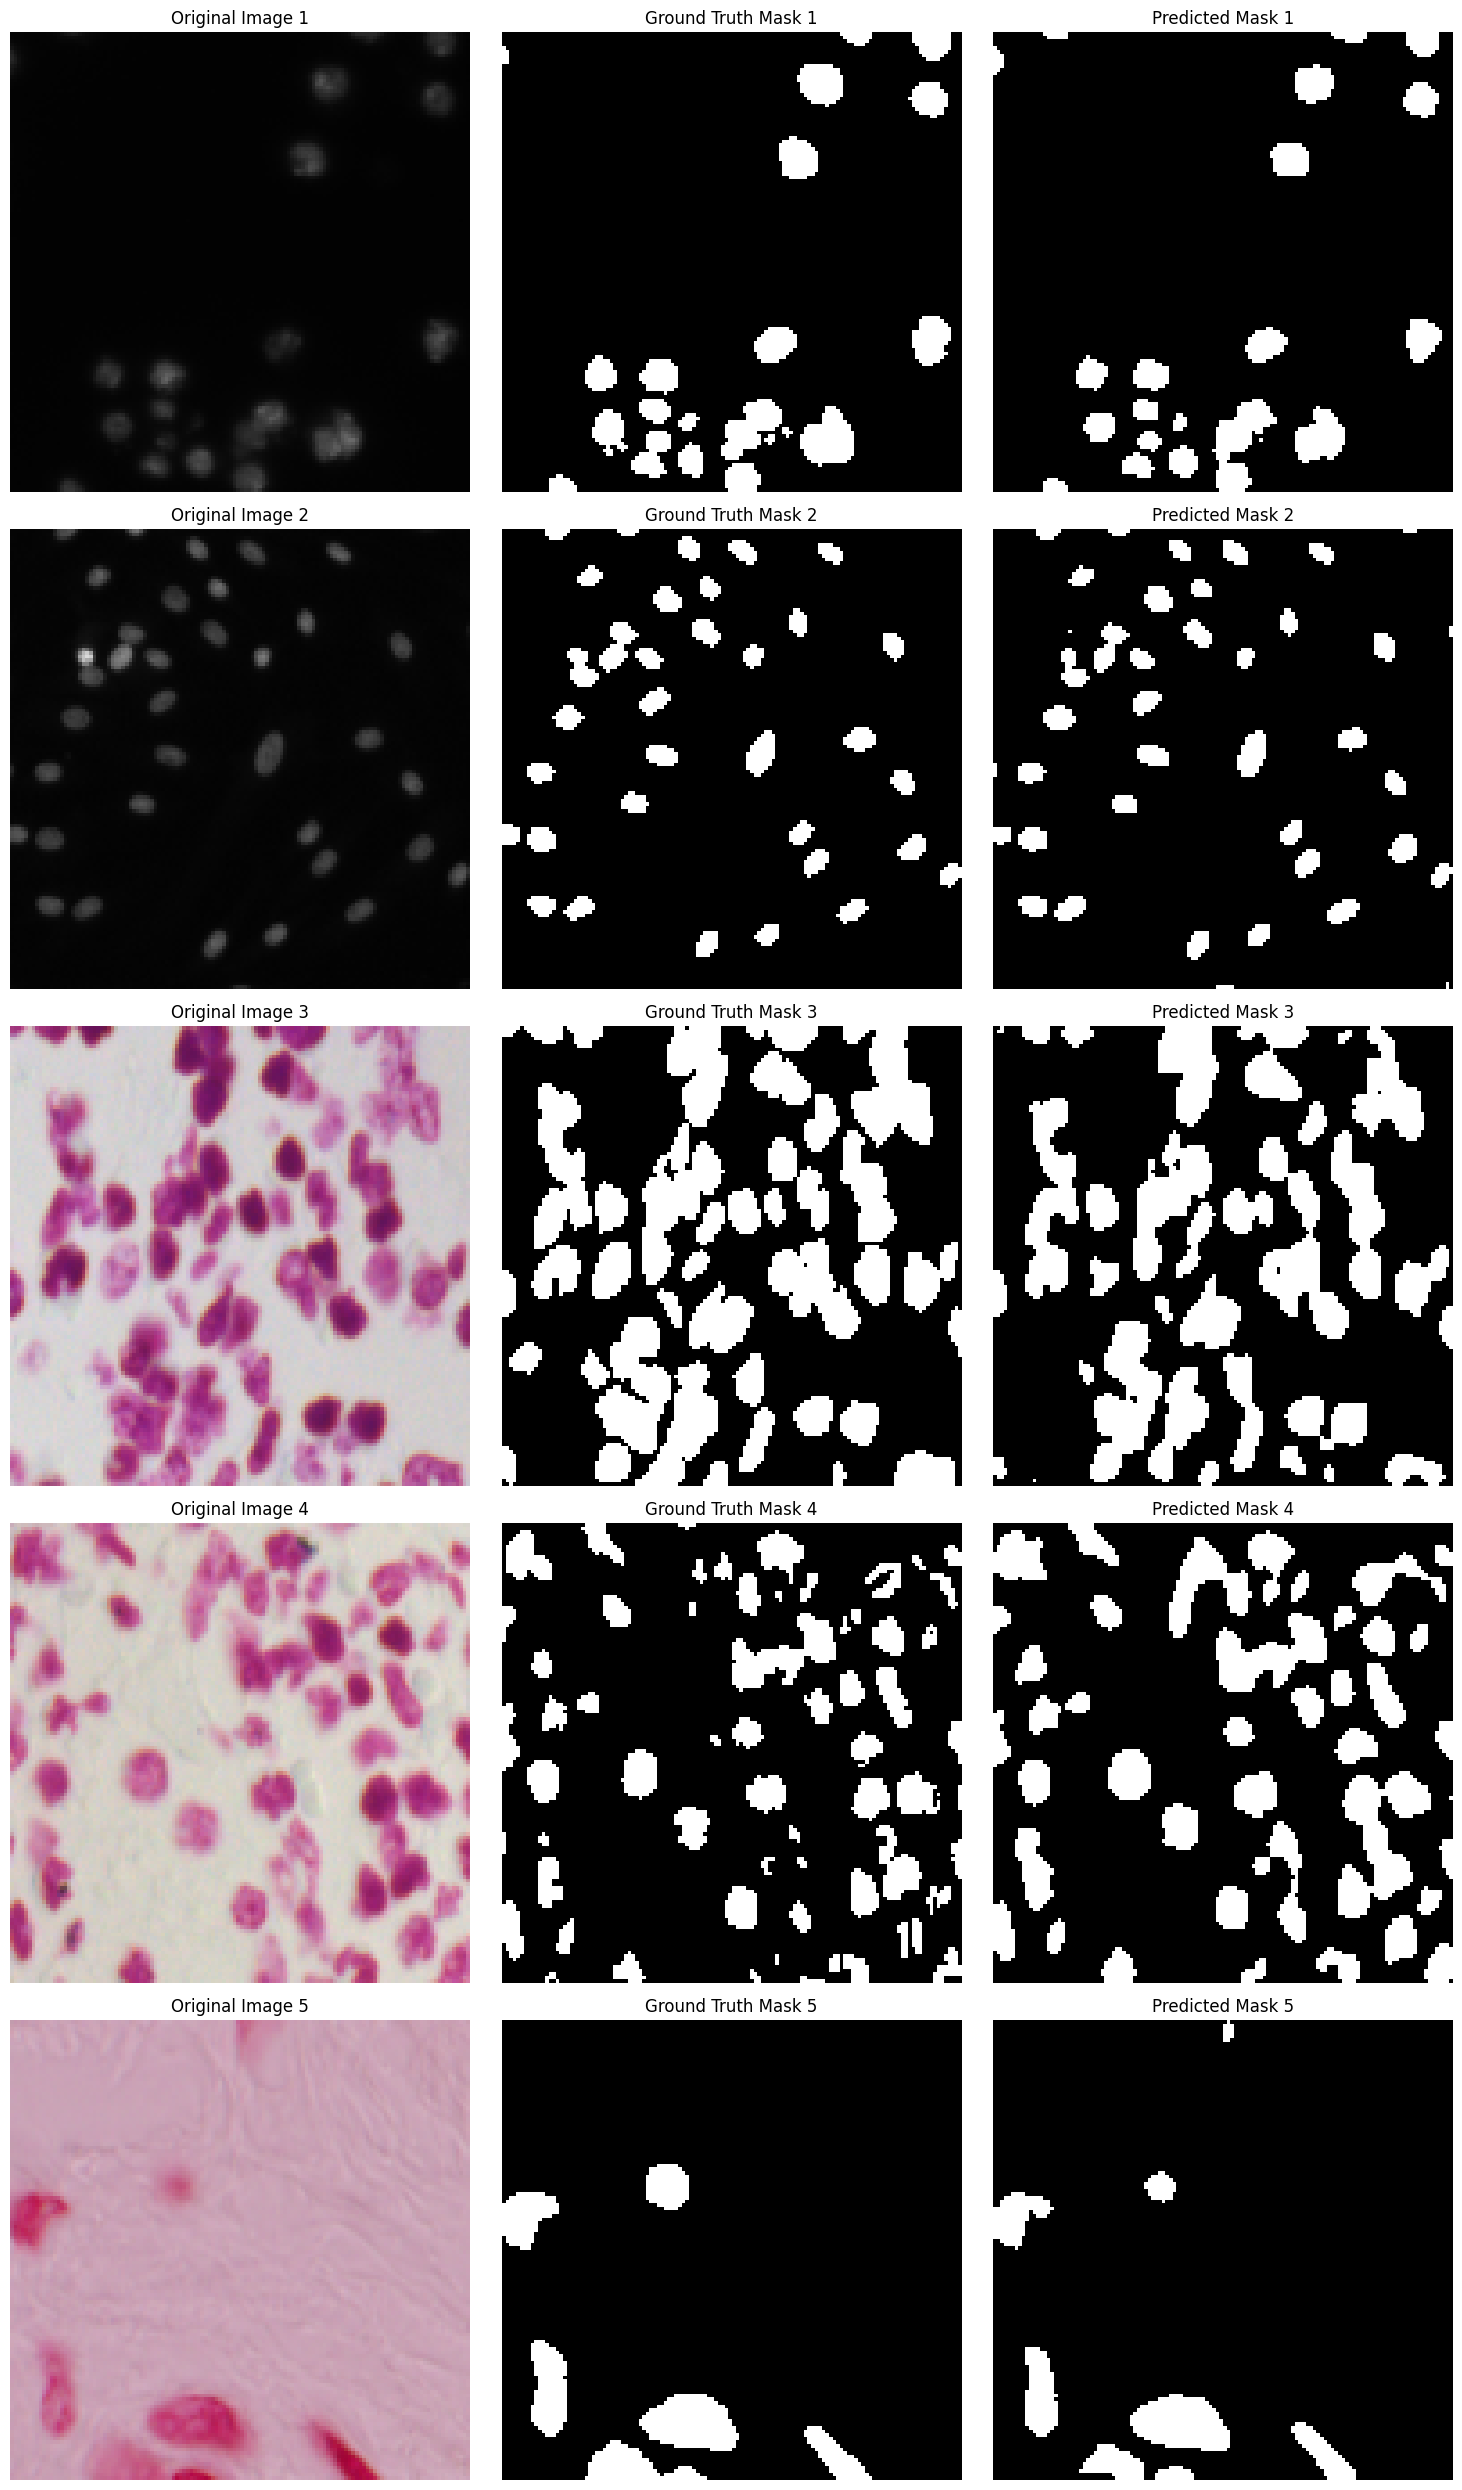

In [30]:
def visualize_predictions(images, true_masks, predicted_masks, num_samples=5):
    """Visualizes the original images, true masks, and predicted masks."""
    plt.figure(figsize=(15, num_samples * 5))
    
    for i in range(num_samples):
        # Plot the original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        # Plot the ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title(f'Ground Truth Mask {i+1}')
        plt.axis('off')

        # Plot the predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title(f'Predicted Mask {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Binarize the true masks for comparison
train_masks_binary = (train_masks > 0.5).astype(np.uint8)

# Predict on the training set (or test set if applicable)
train_predictions = model.predict(train_images)

# Binarize the predicted masks
train_predictions_binary = (train_predictions > 0.5).astype(np.uint8)

# Call the function to visualize a few samples
visualize_predictions(train_images, train_masks_binary, train_predictions_binary, num_samples=5)